In [1]:
import time
import math

import numpy as np
import pandas as pd
from itertools import product
from Database.services.database import Database
from sqlalchemy import inspect
from services.data_retreival import *
from scipy.stats import gmean
import matplotlib.pyplot as plt
from services.strategies import *
from services.optimization_layers import *
from services.optimization import *
from services.binary_optimization import *
from services.environment_functions import *
from services.big_m_strategies import *
from services.experiments import *
from services.plotting_functions import *

Database.initialize("sqlite:///Database//financial_db.sqlite") #for courses replace this with a flat file
inspector = inspect(Database.engine)
print(inspector.get_table_names())

universe = 'SP'
if universe == 'ETF':
    imputation_method = 'Univariate' # 'Multivariate for SP'
    ticker_str = 'SPY'
else:
    imputation_method = 'Multivariate' # 'Multivariate for SP'
    ticker_str = 'AAPL' 
# exponential params

adjClose = pd.read_csv("flat_files/MonthlyAssetPrices"+ universe + ".csv", index_col=0, header = 1).iloc[1:,:]

daily_adjClose =  pd.read_csv("flat_files/DailyAssetPrices"+universe + ".csv", index_col=0, header = 1).iloc[1:,:]

TechnicalAnalysis = pd.read_csv("flat_files/TechnicalAnalysis" + universe + ".csv", index_col=[0,1])

if universe ==  'SP':
    FinancialRatios = pd.read_csv("flat_files/" + imputation_method + "WRDS.csv", index_col=[0,1])
    TechnicalAnalysis.index.names = FinancialRatios.index.names
    ContextualInfo = TechnicalAnalysis.merge(FinancialRatios, how = 'left', left_index=True, right_index=True)

else:
    TechnicalAnalysis.index.names = ['date', 'ticker']
    ContextualInfo = TechnicalAnalysis


['asset_id', 'currency_id', 'equities_series', 'equity_index_id', 'exchange_id', 'factor_id', 'factors', 'frequency_id', 'fundamentals', 'metric_id', 'source_id', 'ticker_id', 'ticker_index_membership', 'tiingo_tickers']


In [2]:
adjClose.index = pd.to_datetime(adjClose.index, format='%Y-%m-%d').tz_localize(None)
daily_adjClose.index = pd.to_datetime(daily_adjClose.index, format='%Y-%m-%d').tz_localize(None)
ContextualInfo.index = ContextualInfo.index.set_levels([pd.to_datetime(ContextualInfo.index.levels[0]).tz_localize(None), ContextualInfo.index.levels[1]])

In [3]:
print("The earliest possible start date")
max(daily_adjClose.index.unique()[0], ContextualInfo.index.get_level_values('date').unique()[0], adjClose.index.unique()[0])

The earliest possible start date


Timestamp('1996-11-30 00:00:00')

In [4]:
print("The latest possible start date")
min(daily_adjClose.index.unique()[-1], ContextualInfo.index.get_level_values('date').unique()[-1], adjClose.index.unique()[-1])

The latest possible start date


Timestamp('2023-04-21 00:00:00')

In [5]:
if universe == 'SP':
    start_date = pd.to_datetime('1996-11-30', format = '%Y-%m-%d')
    
    end_date = pd.to_datetime('2022-12-31', format = '%Y-%m-%d')
else:
    start_date = pd.to_datetime('2006-05-31', format = '%Y-%m-%d')
    
    end_date = pd.to_datetime('2022-12-31', format = '%Y-%m-%d')

factors = ('Mkt-RF', 'RF')

factorRet = get_monthly_factors(factors, start_date, end_date, Database)

factorRet = factorRet.droplevel(0, axis = 1)
factorRet.columns = [col.strip() for col in factorRet.columns]

In [6]:
adjClose = adjClose[start_date:end_date]
daily_adjClose = daily_adjClose[start_date:end_date]
idx = pd.IndexSlice
ContextualInfo = ContextualInfo.loc[idx[start_date:end_date, :], :]

In [7]:
# divide the factor returns by 100
factorRet = factorRet/100

#rf and factor returns
#drop the first observation to align the dataset with the returns data that will
#result
factorRet = factorRet.iloc[1:, :]

#rf and factor returns
riskFree = factorRet['RF']
factorRet = factorRet.loc[:,factorRet.columns != 'RF'];

In [8]:
#Identify the tickers and the dates
tickers = adjClose.columns
dates   = factorRet.index

In [9]:
# Calculate the stocks monthly excess returns
# pct change and drop the first null observation
returns = adjClose.pct_change(1).iloc[1:, :]
returns = returns  - np.diag(riskFree.values) @ np.ones_like(returns.values) # risk adjusted returns
# Align the price table to the asset and factor returns tables by discarding the first observation.
adjClose = adjClose.iloc[1:,:]

In [10]:
assert adjClose.index[0] == returns.index[0]
assert adjClose.index[0] == factorRet.index[0]

# Experimental Analysis

In [17]:
# Some strategies (uncomment this or the next cell to pick a strategy to test)
# Strategy = general_strategy(sample_estimator, MVO, NumObs=48)  #the general strategy object takes an estimator function and an optimizer function
# the only constraint is that the estimators outputs are the optimizers inputs
# investor preferences (static throughout the backtest

initialVal = 100000
estimator_str = 'exponential_weighted_estimator_shrinkage'
premium_str = '1'
q = 20

In [18]:
CardMVO_path = "Experiments//"+universe+"//"+"CardMVO"
CardMVO_experiments = pd.read_pickle(CardMVO_path+"//data_dictionary.pkl")
CardMVO_experiments.run.unique() # select run

array(['SunJan212024'], dtype=object)

In [23]:
CardMVO_experiments.groupby(['cardinality_ratio', 'turnover_limit']).uid.count() 

cardinality_ratio  turnover_limit
0.01               0.75              1
                   1                 1
                   1.25              1
0.02               0.75              2
                   1                 2
                   1.25              2
0.03               0.75              2
                   1                 2
                   1.25              2
0.05               0.75              2
                   1                 2
                   1.25              2
0.07               0.75              2
                   1                 2
                   1.25              2
0.09               0.75              2
                   1                 2
                   1.25              2
0.1                0.75              2
                   1                 2
                   1.25              2
0.2                0.75              2
                   1                 2
                   1.25              2
0.4                0.75       

In [26]:
CardMVO_experiments[CardMVO_experiments.cardinality_ratio == '0.09']

,uid,estimator,optimizer,universe,imputation_method,ticker_str,hyperparam_search,NoPeriods,run,C,...,premium,q,q_alpha,separable,target_return_strategy,target_return_strategy_args,ticker_index,tightening_iter_lim,turnover_constraints,turnover_limit
979daa96e330dc2f2fac4dde817bf6305904e312,979daa96e330dc2f2fac4dde817bf6305904e312,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,1,1,0.6838,False,premium_target,['premium'],0,1,True,0.75
b237b601ab395d45dcf9da4f54d3c591dc7d2f42,b237b601ab395d45dcf9da4f54d3c591dc7d2f42,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,1,1,0.6838,False,premium_target,['premium'],0,1,True,1
48998d68a83d6e5e721cb61bd7de3cc1002a514f,48998d68a83d6e5e721cb61bd7de3cc1002a514f,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,1,1,0.6838,False,premium_target,['premium'],0,1,True,1.25
1cc3c01f6f8986d9ef26888ee3435a180f52a0ac,1cc3c01f6f8986d9ef26888ee3435a180f52a0ac,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,1,20,0.6838,False,premium_target,['premium'],0,1,True,0.75
ea9d007edf9ff753a6ecd8e9eb6fd9a91772362b,ea9d007edf9ff753a6ecd8e9eb6fd9a91772362b,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,1,20,0.6838,False,premium_target,['premium'],0,1,True,1
dfef9c3b5c0d8be81800ec7cc79cf85bc4eee867,dfef9c3b5c0d8be81800ec7cc79cf85bc4eee867,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,1,20,0.6838,False,premium_target,['premium'],0,1,True,1.25


In [27]:
# Filtering step for CardMVO experiments
CardMVO_experiments = CardMVO_experiments[CardMVO_experiments.estimator == estimator_str]
CardMVO_experiments = CardMVO_experiments[CardMVO_experiments.premium == premium_str]
CardMVO_experiments = CardMVO_experiments[CardMVO_experiments.q == str(q)]
assert (CardMVO_experiments.groupby(['cardinality_ratio', 'turnover_limit']).uid.count() == 1).all()

In [28]:
unique_card_turnover_df = CardMVO_experiments.groupby(['cardinality_ratio', 'turnover_limit']).uid.first() # unique experiments
unique_card_turnover_df

cardinality_ratio  turnover_limit
0.02               0.75              d132592cb9d062fdf175bde1a95f372e8be0dbfb
                   1                 326351fc9a7d1b2473e3af348ae20e2e9fb482c6
                   1.25              9f08e44dcf0703f78da027d65ca10681831e7ce4
0.03               0.75              43db33b1039d4a687b71e23d018ad391a53dbd1d
                   1                 59c462c7e438857a530185aef23e89601b3497ba
                   1.25              95ae3e2ffcfbd1fefb689a1263c1622bc338efc8
0.05               0.75              dbf445ff6a57c3de26f42765edcfe9df3e14f792
                   1                 49888b7b0c38373927c39cf9032f727bf9d84c05
                   1.25              412a8ad72531a63ca5ca5bae7f48d8d392817a83
0.07               0.75              c9a27fc308d8ad16da05a797b51f56bab1e5c074
                   1                 2da23224eb3dfc34f0301a462e443fd176e80700
                   1.25              8b9074fa094e55649155df4c02fef0dc5a5aa70f
0.09               0.75       

In [29]:
CardMVO_experiments

,uid,estimator,optimizer,universe,imputation_method,ticker_str,hyperparam_search,NoPeriods,run,C,...,premium,q,q_alpha,separable,target_return_strategy,target_return_strategy_args,ticker_index,tightening_iter_lim,turnover_constraints,turnover_limit
d132592cb9d062fdf175bde1a95f372e8be0dbfb,d132592cb9d062fdf175bde1a95f372e8be0dbfb,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,1,20,0.6838,False,premium_target,['premium'],0,1,True,0.75
326351fc9a7d1b2473e3af348ae20e2e9fb482c6,326351fc9a7d1b2473e3af348ae20e2e9fb482c6,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,1,20,0.6838,False,premium_target,['premium'],0,1,True,1
9f08e44dcf0703f78da027d65ca10681831e7ce4,9f08e44dcf0703f78da027d65ca10681831e7ce4,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,1,20,0.6838,False,premium_target,['premium'],0,1,True,1.25
43db33b1039d4a687b71e23d018ad391a53dbd1d,43db33b1039d4a687b71e23d018ad391a53dbd1d,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,1,20,0.6838,False,premium_target,['premium'],0,1,True,0.75
59c462c7e438857a530185aef23e89601b3497ba,59c462c7e438857a530185aef23e89601b3497ba,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,1,20,0.6838,False,premium_target,['premium'],0,1,True,1
95ae3e2ffcfbd1fefb689a1263c1622bc338efc8,95ae3e2ffcfbd1fefb689a1263c1622bc338efc8,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,1,20,0.6838,False,premium_target,['premium'],0,1,True,1.25
dbf445ff6a57c3de26f42765edcfe9df3e14f792,dbf445ff6a57c3de26f42765edcfe9df3e14f792,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,1,20,0.6838,False,premium_target,['premium'],0,1,True,0.75
49888b7b0c38373927c39cf9032f727bf9d84c05,49888b7b0c38373927c39cf9032f727bf9d84c05,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,1,20,0.6838,False,premium_target,['premium'],0,1,True,1
412a8ad72531a63ca5ca5bae7f48d8d392817a83,412a8ad72531a63ca5ca5bae7f48d8d392817a83,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,1,20,0.6838,False,premium_target,['premium'],0,1,True,1.25
c9a27fc308d8ad16da05a797b51f56bab1e5c074,c9a27fc308d8ad16da05a797b51f56bab1e5c074,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,1,20,0.6838,False,premium_target,['premium'],0,1,True,0.75


In [30]:
# read in SVMMVO experiments and see what is going on
SVMMVO_path_q = "Experiments//"+universe+"//"+"ClassWgtSVMMVO"+"//"+str(q)
SVMMVO_experiments_q = pd.read_pickle(SVMMVO_path_q+"//data_dictionary.pkl")
print("q =", q, " runs available: ", SVMMVO_experiments_q.run.unique())

q = 20  runs available:  ['SunJan212024']


In [31]:
SVMMVO_experiments_q

,uid,estimator,optimizer,universe,imputation_method,ticker_str,hyperparam_search,NoPeriods,run,C,...,premium,q,q_alpha,separable,target_return_strategy,target_return_strategy_args,ticker_index,tightening_iter_lim,turnover_constraints,turnover_limit
58d46c04cbd53a56435753d1b4df05f1cbb6f77e,58d46c04cbd53a56435753d1b4df05f1cbb6f77e,exponential_weighted_estimator_shrinkage,ClassWgtSVMMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,1,20,0.6838,False,premium_target,['premium'],0,1,True,0.75
b1fa961a0d0141186be5cecaab925fd24cc36ad1,b1fa961a0d0141186be5cecaab925fd24cc36ad1,exponential_weighted_estimator_shrinkage,ClassWgtSVMMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,1,20,0.6838,False,premium_target,['premium'],0,1,True,0.75
515fe2720cf20e9b000680f496ce96927985d8b7,515fe2720cf20e9b000680f496ce96927985d8b7,exponential_weighted_estimator_shrinkage,ClassWgtSVMMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,1,20,0.6838,False,premium_target,['premium'],0,1,True,0.75
f05f5910c321e0345c7e87355963397bf8076917,f05f5910c321e0345c7e87355963397bf8076917,exponential_weighted_estimator_shrinkage,ClassWgtSVMMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,1,20,0.6838,False,premium_target,['premium'],0,1,True,0.75
637686b1c80aaa306aa966c66450bd8a56eed5c9,637686b1c80aaa306aa966c66450bd8a56eed5c9,exponential_weighted_estimator_shrinkage,ClassWgtSVMMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,1,20,0.6838,False,premium_target,['premium'],0,1,True,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d155ea42019c1478b8836594e5b6aface8de3dcd,d155ea42019c1478b8836594e5b6aface8de3dcd,exponential_weighted_estimator_shrinkage,ClassWgtSVMMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,1,20,0.6838,False,premium_target,['premium'],0,1,True,1.25
bfeb96efde12b0c671f651c8721907fcf4fa7dec,bfeb96efde12b0c671f651c8721907fcf4fa7dec,exponential_weighted_estimator_shrinkage,ClassWgtSVMMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,1,20,0.6838,False,premium_target,['premium'],0,1,True,1.25
4a368e2fad9655d6f04cd38ee575cf52290e9a9c,4a368e2fad9655d6f04cd38ee575cf52290e9a9c,exponential_weighted_estimator_shrinkage,ClassWgtSVMMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,1,20,0.6838,False,premium_target,['premium'],0,1,True,1.25
cb68ac82d869a95524649ed5ffbec6f6f30579d0,cb68ac82d869a95524649ed5ffbec6f6f30579d0,exponential_weighted_estimator_shrinkage,ClassWgtSVMMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,1,20,0.6838,False,premium_target,['premium'],0,1,True,1.25


In [32]:
SVMMVO_experiments_q.drop_duplicates().groupby(['kappa', 'cardinality_ratio']).uid.count()

kappa   cardinality_ratio
0.0125  0.02                 3
        0.03                 3
        0.05                 3
        0.07                 3
        0.09                 3
                            ..
0.8     0.1                  3
        0.2                  3
        0.4                  3
        0.6                  3
        0.8                  3
Name: uid, Length: 70, dtype: int64

In [33]:
SVMMVO_experiments_q.drop_duplicates().groupby(['cardinality_ratio', 'turnover_limit', 'kappa']).uid.count()

cardinality_ratio  turnover_limit  kappa 
0.02               0.75            0.0125    1
                                   0.025     1
                                   0.05      1
                                   0.1       1
                                   0.2       1
                                            ..
0.8                1.25            0.05      1
                                   0.1       1
                                   0.2       1
                                   0.4       1
                                   0.8       1
Name: uid, Length: 210, dtype: int64

In [34]:
SVMMVO_experiments_q.estimator.unique()

array(['exponential_weighted_estimator_shrinkage'], dtype=object)

In [35]:
cardinality_ratios = np.sort(SVMMVO_experiments_q.cardinality_ratio.unique())
cardinality_ratios

array(['0.02', '0.03', '0.05', '0.07', '0.09', '0.1', '0.2', '0.4', '0.6',
       '0.8'], dtype=object)

In [36]:
kappas = np.sort(SVMMVO_experiments_q.kappa.unique())
kappas

array(['0.0125', '0.025', '0.05', '0.1', '0.2', '0.4', '0.8'],
      dtype=object)

In [37]:
# filtering step
SVMMVO_experiments_q =SVMMVO_experiments_q[SVMMVO_experiments_q.estimator == estimator_str]
assert (SVMMVO_experiments_q.groupby(['cardinality_ratio', 'turnover_limit', 'kappa']).uid.count() == 1).all()

In [38]:
# prepare the results dictionary
CardMVO_results = {}
MVO_results = {}

for i in unique_card_turnover_df.index:
    CardMVO_results[i] = import_experimental_results(CardMVO_path, unique_card_turnover_df[i])
    if float(i[0]) > 0.99: # no restrictions on cardinality
        MVO_results[i[1]] = import_experimental_results(CardMVO_path, unique_card_turnover_df[i]) #MVO dict is a function of turnover

In [39]:
# prepare the results dictionary for
unique_svmmvo_turnover_df = SVMMVO_experiments_q.groupby(['cardinality_ratio', 'turnover_limit', 'kappa']).uid.first()
SVMMVO_results_q = {}
SVMMVO_path_q = "Experiments//"+universe+"//"+"ClassWgtSVMMVO"+"//"+str(q)
for i in unique_svmmvo_turnover_df.index:
    SVMMVO_results_q[i] = import_experimental_results(SVMMVO_path_q, unique_svmmvo_turnover_df[i])

In [40]:
def plot_results_relative_ticker(CardMVO_results, MVO_results, SVMMVO_results_q, turnovers, cardinalities, q, kappas
                                 , adjClose, initialVal=100000, ticker_str='SPY', figsize=(8.5, 10.5)):

    lw = 1
    win_count = 0
    loss_count = 0

    fig, axs = plt.subplots(len(cardinalities), len(turnovers),
                            sharex=True, sharey='row', figsize=figsize)

    if len(cardinalities) == 1:
        axs = np.expand_dims(axs, axis=0)
    if len(turnovers) == 1:
        axs = np.expand_dims(axs, axis=1)

    CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                      '#f781bf', '#a65628', '#984ea3',
                      '#999999', '#e41a1c', '#dede00']
    win_rates = {}
    loss_rates = {}
    for kappa in kappas:
        win_rates[kappa] = 0
        loss_rates[kappa] = 0
    # load in the appropriate files
    for i in range(len(cardinalities)):

        max_y = 1.05
        min_y = 0.95

        for j in range(len(turnovers)):
            turnover_lim = turnovers[j]
            card = cardinalities[i]
            card_mvo_wealth, elapsed_time, x, turnover = CardMVO_results[(str(card), str(turnover_lim))]
            if ticker_str is not None:
                value_target_index = adjClose.loc[card_mvo_wealth.index, ticker_str]
                time0 = value_target_index.index[0] - pd.offsets.MonthEnd(1)
                spy_time0 = adjClose.loc[time0, ticker_str]
                value_target_index = initialVal * value_target_index / spy_time0

            card_mvo_wealth.columns = ['Card-MVO']

            # mvo_wealth, elapsed_time, x, turnover = MVO_results[str(turnover_lim)]
            # mvo_wealth.columns = ['MVO']
            #
            # card_mvo_rel_wealth = pd.Series(card_mvo_wealth.values.flatten() / mvo_wealth.values.flatten(),
            #                                 index=card_mvo_wealth.index)
            # mvo_wealth_rel_wealth = pd.Series(mvo_wealth.values.flatten() / value_target_index.values.flatten(),
            #                                   index=mvo_wealth.index)
            index_rel_wealth = pd.Series(value_target_index.values.flatten() / card_mvo_wealth.values.flatten(),
                                            index=card_mvo_wealth.index)

            k = 0
            for kappa in kappas:
                svmmvo_wealth, elapsed_time, x, turnover = SVMMVO_results_q[(str(card), str(turnover_lim), str(kappa))]
                svmmvo_wealth.columns = ['SVMMVO-'+str(q)]
                svmmvo_rel_wealth = pd.Series(svmmvo_wealth.values.flatten() / card_mvo_wealth.values.flatten(),
                                            index=svmmvo_wealth.index)

                if k%2 == 0:
                    style =  '-'# '(0, (3, 1, 1, 1))
                else:
                    style = '-'
                svmmvo_rel_wealth.plot(fontsize=6, ax=axs[i, j], linewidth=lw, linestyle=style,
                                       legend=False,
                                       label='SVMMVO-'+str(q)+r' $\kappa =$' + str(kappa), rot=45, color = CB_color_cycle[k])
                k+=1
                if svmmvo_rel_wealth.iloc[-1] > 1.05:
                    win_count += 1
                    win_rates[kappa] += 1
                elif svmmvo_rel_wealth.iloc[-1] < 0.95:
                    loss_count += 1
                    loss_rates[kappa] += 1
                max_ = svmmvo_rel_wealth.max() #card_mvo_rel_wealth.max()  # [0]
                min_ = svmmvo_rel_wealth.min()
                # print(max_)
                if max_ > max_y:
                    max_y = max_
                if min_ < min_y:
                    min_y = min_
            # if ticker_str is not None:
            # value_target_index.plot(fontsize = 8, ax=axs[i, j], linewidth = lw, legend = False)
            #print(svmmvo_rel_wealth.max())
            card_string = r"$K = \lfloor "+str(card)+ r"N \rfloor$"
            turnover_string = "$C_0 = "+str(turnover_lim)+"$"

            axs[i, j].set_title(card_string + ", " + turnover_string, fontsize = 6)
            # print(card_mvo_wealth.max()[0])
            axs[i, j].tick_params(axis='x', labelsize=6)
            axs[i, j].tick_params(axis='y', labelsize=6)
            axs[i, j].yaxis.set_tick_params(which='minor', bottom=False)
            min_y = math.floor(min_y*10)/10
            spacing = (max_y - min_y)/5
            spacing = 0.05*math.ceil(spacing/0.1)
            axs[i, j].set_yticks([min_y + i * spacing for i in range(2 + int((max_y - min_y) / spacing))])
            axs[i, j].grid()
            axs[i, j].set_xlabel("Date", fontsize = 5)

    axs[len(cardinalities) - 1, 0].legend(loc='upper center',
                                          bbox_to_anchor=(1.5, -0.6),
                                          fancybox=False,
                                          shadow=False, ncol=3,
                                          fontsize = 6)

    # min_y = math.floor(min_y*10)/10
    # spacing = (max_y - min_y)/5
    # spacing = 0.05*math.ceil(spacing/0.1)
    # axs[len(cardinalities) - 1, 0].set_yticks([min_y + i * spacing for i in range(2 + int((max_y - min_y) / spacing))])
    # #axs[len(cardinalities) - 1, 0].grid()
    # axs[len(cardinalities) - 1, 0].set_xlabel("Date", fontsize = 5)

    fig.supylabel("Cumulative Relative Wealth", fontsize = 6)
    plt.tight_layout()
    fig.subplots_adjust(wspace=0.05, hspace=0.4)
    print("Number of instances where SVMMVO won ", win_count)
    print("Number of instances where SVMMVO lost ", loss_count)
    print("Number of instances ", len(cardinalities)*len(turnovers)*len(kappas))
    print("% of instances where SVMMVO won ", win_count/(len(cardinalities)*len(turnovers)*len(kappas)))
    print("% of instances where SVMMVO lost ", loss_count/(len(cardinalities)*len(turnovers)*len(kappas)))
    return win_rates, loss_rates

In [61]:
if universe == 'ETF':
    kappas_plot = kappas[1:7]
    cardinality_ratios = [0.01, 0.03, 0.05, 0.07, 0.09, 0.2, 0.4, 0.6, 0.8] #[0.01, 0.03, 0.05, 0.07, 0.09]#[0.1, 0.2, 0.4, 0.6] #[0.03, 0.05, 0.07, 0.09] # includes mvo
else:
    kappas_plot = kappas[0:3]
    cardinality_ratios = [0.02, 0.03, 0.05, 0.07, 0.09, 0.2, 0.4, 0.6, 0.8] #[0.01, 0.03, 0.05, 0.07, 0.09]#[0.1, 0.2, 0.4, 0.6] #[0.03, 0.05, 0.07, 0.09] # includes mvo

Number of instances where SVMMVO won  20
Number of instances where SVMMVO lost  21
Number of instances  81
% of instances where SVMMVO won  0.24691358024691357
% of instances where SVMMVO lost  0.25925925925925924
images/SVMMVO_SP_20.svg


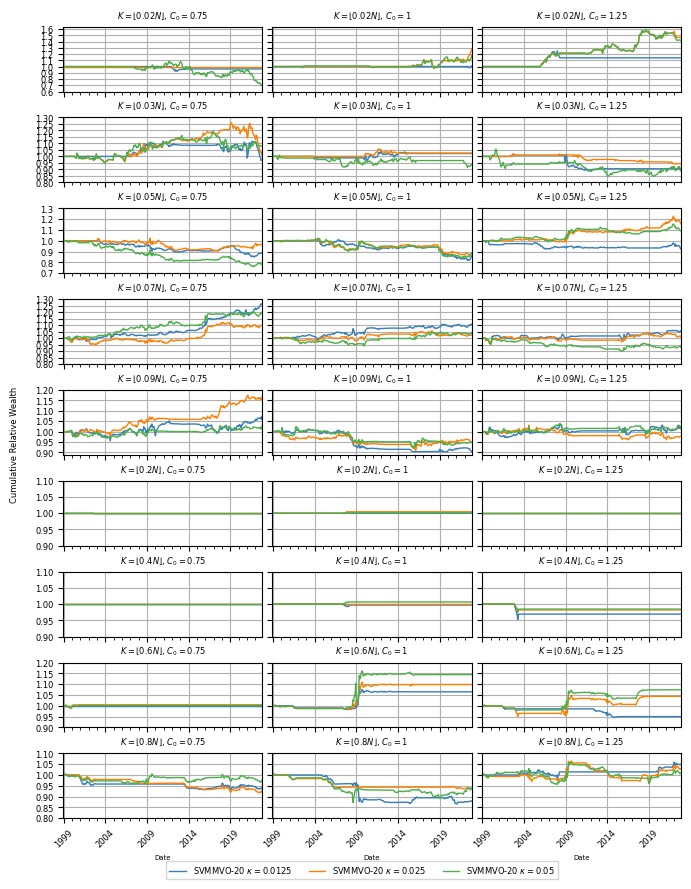

In [62]:
turnover_limits = [0.75, 1, 1.25]

win_rates, loss_rates = plot_results_relative_ticker(CardMVO_results, MVO_results, SVMMVO_results_q,
                             turnover_limits, cardinality_ratios, q, kappas_plot,
                             adjClose, initialVal=100000, ticker_str=ticker_str, figsize=(7, 9))
print("images/SVMMVO_"+universe + "_" + str(q) + ".svg")
plt.savefig("images/SVMMVO_"+universe + "_" + str(q) + ".svg")

In [59]:
win_rates

{'0.0125': 7, '0.025': 6, '0.05': 7, '0.1': 5, '0.2': 3, '0.4': 6, '0.8': 3}

In [60]:
loss_rates

{'0.0125': 8,
 '0.025': 5,
 '0.05': 8,
 '0.1': 11,
 '0.2': 14,
 '0.4': 14,
 '0.8': 15}

In [52]:
win_loss_ratio = {kappa: win_rates[kappa]/loss_rates[kappa] for kappa in kappas_plot}
win_loss_ratio

ZeroDivisionError: division by zero

In [53]:
mvo_wealth, elapsed_time, x_mvo, turnover = CardMVO_results[('1', '0.75')]
calculate_return_stats(mvo_wealth, riskFree)

(0.0939611687906643, 0.12844136017924415, 0.7315491572149219)

In [54]:
(x_mvo > 10**(-12)).sum(axis = 0)/len(x_mvo)

array([1.        , 0.81270903, 1.        , 0.05685619, 0.92307692,
       0.74247492, 0.03344482, 1.        , 1.        , 0.58862876,
       0.99665552, 1.        , 0.07692308, 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.13712375, 1.        ,
       1.        , 1.        , 0.11705686, 1.        , 0.96989967,
       1.        , 1.        , 1.        , 1.        ])

In [58]:
card_mvo_wealth, elapsed_time, x_card_mvo, turnover = CardMVO_results[('0.01', '0.75')]
calculate_return_stats(card_mvo_wealth, riskFree)

(0.09038161961300961, 0.20880141106477276, 0.4328592376464932)

In [59]:
(x_card_mvo > 10**(-12)).sum(axis = 0)/len(x_card_mvo)

array([0.00668896, 0.00668896, 0.00668896, 0.00668896, 0.00668896,
       0.00668896, 0.00668896, 0.00668896, 0.00668896, 0.00668896,
       0.00668896, 0.00668896, 0.00668896, 0.00668896, 0.00668896,
       0.00668896, 0.00668896, 0.00668896, 0.00668896, 0.00668896,
       0.00668896, 0.00668896, 0.00668896, 0.00668896, 0.00668896,
       0.00668896, 0.00668896, 0.00668896, 0.00668896])

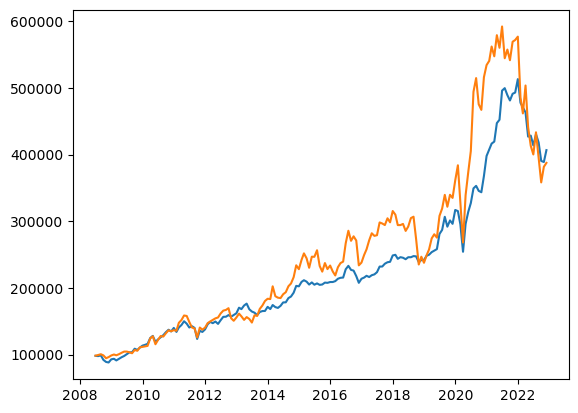

In [60]:
plt.plot(mvo_wealth)
plt.plot(card_mvo_wealth)

In [995]:
def make_stats_table(CardMVO_results, MVO_results, SVMMVO_results_q,
                             turnovers, cardinalities, q, kappas_plot, riskFree):
    df_cols = []
    # load in the appropriate files

    for j in range(len(turnovers)):
        df_rows = []
        turnover_lim = turnovers[j]
        turnover_string = "$C_0 = "+str(turnover_lim)+"$"
        mvo_wealth, elapsed_time, x, turnover = MVO_results[str(turnover_lim)]
        mvo_wealth.columns = ['MVO']

        mvo_ret_stats = calculate_return_stats(mvo_wealth, riskFree)
        ret_stats = [mvo_ret_stats]
        
        row_tuples = [(turnover_string, '', "MVO", "")]
        row_index = pd.MultiIndex.from_tuples(row_tuples)
        col_index = [ "$\mu$",  "$\sigma$", "S.R", "Sortino"]  # , (card_string,"Sortino.R")]
        
        out = pd.DataFrame(ret_stats, index=row_index, columns=col_index)
        df_rows.append(out)
        
        for i in range(len(cardinalities)):
            
            card = cardinalities[i]
            card_mvo_wealth, elapsed_time, x, turnover = CardMVO_results[(str(card), str(turnover_lim))]

            card_mvo_wealth.columns = ['Card-MVO']

           
            card_ret_stats = calculate_return_stats(card_mvo_wealth, riskFree)

            card_string = r"$K = \lfloor "+str(card)+ r"N \rfloor$"


            row_tuples = [(turnover_string, card_string, "Card MVO", "")]
            row_index = pd.MultiIndex.from_tuples(row_tuples)

            #col_index = pd.MultiIndex.from_tuples(col_tuples)
            ret_stats = [card_ret_stats]

            out = pd.DataFrame(ret_stats, index=row_index, columns=col_index)

            df_rows.append(out)
            
            for kappa in kappas:
                svmmvo_wealth, elapsed_time, x, turnover = SVMMVO_results_q[(str(card), str(turnover_lim), str(kappa))]
                svmmvo_wealth.columns = ['SVMMVO-'+str(q)]
                svmmvo_ret_stats = calculate_return_stats(svmmvo_wealth, riskFree)
    
                kappa_str = r'$\kappa =$' + str(kappa)
                row_tuples = [(turnover_string, card_string, "SVMMVO "+ str(q), kappa_str )]
                row_index = pd.MultiIndex.from_tuples(row_tuples)


                ret_stats = [svmmvo_ret_stats]
    
                out = pd.DataFrame(ret_stats, index=row_index, columns=col_index)
    
                df_rows.append(out)

        column = pd.concat(df_rows)
        #print(column)
        df_cols.append(column)

    return pd.concat(df_cols, axis=0)

In [996]:
df = make_stats_table(CardMVO_results, MVO_results, SVMMVO_results_q,
                             turnover_limits, cardinality_ratios, q, kappas_plot, riskFree)

df

$\mu$  \
$C_0 = 0.75$                             MVO                       0.093961   
             $K = \lfloor 0.03N \rfloor$ Card MVO                  0.091038   
                                         SVMMVO 2 $\kappa =$0.025  0.092664   
                                                  $\kappa =$0.05   0.092770   
                                                  $\kappa =$0.1    0.094395   
...                                                                     ...   
$C_0 = 1.25$ $K = \lfloor 0.6N \rfloor$  SVMMVO 2 $\kappa =$0.1    0.077018   
                                                  $\kappa =$0.2    0.076882   
                                                  $\kappa =$0.4    0.077943   
                                                  $\kappa =$0.8    0.078378   
                                                  $\kappa =$1.6    0.079536   

                                                                   $\sigma$  \
$C_0 = 0.75$                             MVO                       0.128441   
             $K = \lfloor 0.03N \rfloor$ Card MVO                  0.129901   
                                         SVMMVO 2 $\kappa =$0.025  0.129326   
                                                  $\kappa =$0.05   0.129961   
                                                  $\kappa =$0.1    0.125879   
...                                                                     ...   
$C_0 = 1.25$ $K = \lfloor 0.6N \rfloor$  SVMMVO 2 $\kappa =$0.1    0.115045   
                                                  $\kappa =$0.2    0.115859   
                                                  $\kappa =$0.4    0.118675   
                                                  $\kappa =$0.8    0.119459   
                                                  $\kappa =$1.6    0.122102   

                                                                        S.R  \
$C_0 = 0.75$                             MVO                       0.731549   
             $K = \lfloor 0.03N \rfloor$ Card MVO                  0.700826   
                                         SVMMVO 2 $\kappa =$0.025  0.716518   
                                                  $\kappa =$0.05   0.713831   
                                                  $\kappa =$0.1    0.749889   
...                                                                     ...   
$C_0 = 1.25$ $K = \lfloor 0.6N \rfloor$  SVMMVO 2 $\kappa =$0.1    0.669466   
                                                  $\kappa =$0.2    0.663582   
                                                  $\kappa =$0.4    0.656780   
                                                  $\kappa =$0.8    0.656110   
                                                  $\kappa =$1.6    0.651384   

                                                                    Sortino  
$C_0 = 0.75$                             MVO                       0.988549  
             $K = \lfloor 0.03N \rfloor$ Card MVO                  0.971154  
                                         SVMMVO 2 $\kappa =$0.025  0.993244  
                                                  $\kappa =$0.05   0.964228  
                                                  $\kappa =$0.1    1.026525  
...                                                                     ...  
$C_0 = 1.25$ $K = \lfloor 0.6N \rfloor$  SVMMVO 2 $\kappa =$0.1    0.847376  
                                                  $\kappa =$0.2    0.842105  
                                                  $\kappa =$0.4    0.819526  
                                                  $\kappa =$0.8    0.840385  
                                                  $\kappa =$1.6    0.802948  

[171 rows x 4 columns]

In [997]:
df.stack().unstack(level = 0).unstack(level = -1)

$C_0 = 0.75$            \
                                                            $\mu$  $\sigma$   
                            MVO                          0.093961  0.128441   
$K = \lfloor 0.03N \rfloor$ Card MVO                     0.091038  0.129901   
                            SVMMVO 2 $\kappa =$0.025     0.092664  0.129326   
                                     $\kappa =$0.05      0.092770  0.129961   
                                     $\kappa =$0.1       0.094395  0.125879   
                                     $\kappa =$0.2       0.086943  0.128234   
                                     $\kappa =$0.4       0.092263  0.129154   
                                     $\kappa =$0.8       0.089106  0.131823   
                                     $\kappa =$1.6       0.085815  0.140559   
$K = \lfloor 0.05N \rfloor$ Card MVO                     0.095883  0.128883   
                            SVMMVO 2 $\kappa =$0.025     0.095139  0.128215   
                                     $\kappa =$0.05      0.094795  0.127992   
                                     $\kappa =$0.1       0.096763  0.130071   
                                     $\kappa =$0.2       0.097108  0.126583   
                                     $\kappa =$0.4       0.091665  0.127584   
                                     $\kappa =$0.8       0.090204  0.126853   
                                     $\kappa =$1.6       0.096609  0.144449   
$K = \lfloor 0.07N \rfloor$ Card MVO                     0.096576  0.128488   
                            SVMMVO 2 $\kappa =$0.025     0.093884  0.128572   
                                     $\kappa =$0.05      0.093908  0.128502   
                                     $\kappa =$0.1       0.094741  0.129079   
                                     $\kappa =$0.2       0.096196  0.125593   
                                     $\kappa =$0.4       0.091480  0.129822   
                                     $\kappa =$0.8       0.096187  0.128334   
                                     $\kappa =$1.6       0.093774  0.122717   
$K = \lfloor 0.09N \rfloor$ Card MVO                     0.094125  0.129064   
                            SVMMVO 2 $\kappa =$0.025     0.094125  0.129064   
                                     $\kappa =$0.05      0.093926  0.128208   
                                     $\kappa =$0.1       0.097946  0.128778   
                                     $\kappa =$0.2       0.091096  0.127348   
                                     $\kappa =$0.4       0.092554  0.129160   
                                     $\kappa =$0.8       0.090501  0.126995   
                                     $\kappa =$1.6       0.094089  0.146099   
$K = \lfloor 0.2N \rfloor$  Card MVO                     0.093961  0.128442   
                            SVMMVO 2 $\kappa =$0.025     0.093961  0.128442   
                                     $\kappa =$0.05      0.093961  0.128442   
                                     $\kappa =$0.1       0.094104  0.127904   
                                     $\kappa =$0.2       0.090434  0.126169   
                                     $\kappa =$0.4       0.103113  0.128279   
                                     $\kappa =$0.8       0.096166  0.130958   
                                     $\kappa =$1.6       0.096963  0.130311   
$K = \lfloor 0.4N \rfloor$  Card MVO                     0.093966  0.128444   
                            SVMMVO 2 $\kappa =$0.025     0.093966  0.128444   
                                     $\kappa =$0.05      0.093966  0.128444   
                                     $\kappa =$0.1       0.098229  0.127582   
                                     $\kappa =$0.2       0.097055  0.127604   
                                     $\kappa =$0.4       0.098576  0.125484   
                                     $\kappa =$0.8       0.097893  0.133467   
                                     $\kappa =$1.6       0.091749  0.130008   
$K = \lfloor 0.6N \rfloo

In [113]:
# print(df.to_latex(index=False,
#                   formatters={"name": str.upper},
#                   float_format="{:.3f}".format,
# ))

In [114]:
def make_turnover_table(CardMVO_results, MVO_results, turnovers, cardinalities, card_strings,
                     turnover_strings):
    df_cols = []
    # load in the appropriate files
    for i in range(len(cardinalities)):

        df_rows = []

        for j in range(len(turnovers)):
            turnover_lim = turnovers[j]
            card = cardinalities[i]
            card_mvo_wealth, elapsed_time, x, turnover = CardMVO_results[(str(card), str(turnover_lim))]
            card_ret_stats = np.mean(turnover[1:])
            card_mvo_wealth.columns = ['Card-MVO']

            mvo_wealth, elapsed_time, x, turnover = MVO_results[str(turnover_lim)]
            mvo_wealth.columns = ['MVO']
            mvo_ret_stats = np.mean(turnover[1:])

            card_string = card_strings[i]
            turnover_string = turnover_strings[j]

            row_tuples = [(turnover_string, "MVO"), (turnover_string, "Card MVO")]
            row_index = pd.MultiIndex.from_tuples(row_tuples)

            col_tuples = [(card_string, "$C_0$")]  # , (card_string,"Sortino.R")]
            col_index = pd.MultiIndex.from_tuples(col_tuples)

            ret_stats = [mvo_ret_stats, card_ret_stats]

            out = pd.DataFrame(ret_stats, index=row_index, columns=col_index)

            df_rows.append(out)

        column = pd.concat(df_rows)
        df_cols.append(column)

    return pd.concat(df_cols, axis=1)

In [458]:
make_turnover_table(CardMVO_results, MVO_results, turnover_limits, cardinality_ratios, card_strings,
                     turnover_strings)

$K = \lfloor 0.01N \rfloor$ $K = \lfloor0.03N\rfloor$  \
                                              $C_0$                     $C_0$   
$C_0 = 0.75/6$ MVO                         0.752611                  0.752611   
               Card MVO                    0.704919                  0.754661   
$C_0 = 1.00/6$ MVO                         0.995194                  0.995194   
               Card MVO                    0.893404                  0.999088   
$C_0 = 1.25/6$ MVO                         1.223032                  1.223032   
               Card MVO                    1.097917                  1.235573   

                        $K = \lfloor0.05N \rfloor$ $K = \lfloor0.07N \rfloor$  \
                                             $C_0$                      $C_0$   
$C_0 = 0.75/6$ MVO                        0.752611                   0.752611   
               Card MVO                   0.754292                   0.755368   
$C_0 = 1.00/6$ MVO                        0.995194                   0.995194   
               Card MVO                   0.996744                   0.995824   
$C_0 = 1.25/6$ MVO                        1.223032                   1.223032   
               Card MVO                   1.226701                   1.230243   

                        $K = \lfloor0.09N \rfloor$  
                                             $C_0$  
$C_0 = 0.75/6$ MVO                        0.752611  
               Card MVO                   0.753900  
$C_0 = 1.00/6$ MVO                        0.995194  
               Card MVO                   0.996763  
$C_0 = 1.25/6$ MVO                        1.223032  
               Card MVO                   1.226559

In [213]:
SVMMVO_path = "Experiments//"+universe+"//SVMMVO//1"

file = '45c51408b46f18afe2a559e09185b1e15aa85aee_experimental_info.pkl'

experiment_file_path = SVMMVO_path + "//" + file
with open(experiment_file_path,  'rb') as fp:
    experimental_results = pkl.load(fp)

FileNotFoundError: [Errno 2] No such file or directory: 'Experiments//ETF//SVMMVO//1//45c51408b46f18afe2a559e09185b1e15aa85aee_experimental_info.pkl'

In [214]:
experimental_results.keys()

dict_keys(['portfValue', 'elapsed_time', 'x', 'turnover'])

In [215]:
CardMVO_results.keys()

dict_keys([('0.01', '0.75'), ('0.01', '1'), ('0.01', '1.25'), ('0.03', '0.75'), ('0.03', '1'), ('0.03', '1.25'), ('0.05', '0.75'), ('0.05', '1'), ('0.05', '1.25'), ('0.07', '0.75'), ('0.07', '1'), ('0.07', '1.25'), ('1', '0.75'), ('1', '1'), ('1', '1.25')])

In [253]:
#q = 5
file5 = '9b38c865a887a417ad3ac94e0ce45f5f7f8e8e5d_experimental_info.pkl'
file5 = 'dafd78cbbac415cf955ea24429f1042ae66082a8_experimental_info.pkl'
#q = 3
file3 = '2d92cebd1ab62721978e6a37523dedec16aebff7_experimental_info.pkl' #0.01
file3 = '5949552183e60896754e808d4afcadec0015b40f_experimental_info.pkl' #0.01
# file3 = '0ef6eae88e31780f38024e0fb46dc25a92e82c6c_experimental_info.pkl' #0.01
#
# file3 = '65874ca85acbd70ac823c2e50f15cd972679b107_experimental_info.pkl' #0.03
# file3 = '4faade72002ccbac457fd03e40a57da5d970fd17_experimental_info.pkl' #0.03
# file3 = '24ddee575d32c5d32e3709493b2f8c84a73cd72d_experimental_info.pkl' #0.03
#
# file3 = '8b5d7f483ddd461b98bbe2b24c2fed43d77e6516_experimental_info.pkl' #0.05
# file3 = '4112c56b8abf7fbe440332a0ab6c6c21fa3e8f6d_experimental_info.pkl' #0.05
# file3 = 'f32b36b54084b8b779e6bc56edfd9a66ec6d23a2_experimental_info.pkl' #0.05
#
# file3 = '3f9dbf52fa5bb5a845f6cbae458bcd92f222aef6_experimental_info.pkl' #0.07
# file3 = '646870ee938f8e3b7e37b2694384f03848311f24_experimental_info.pkl' #0.07
# file3 = '8adbd99a364b232c7fae137b70b05add477202f7_experimental_info.pkl' #0.07

#file3 = '1923bf8396619526d1baccd2be3299573538de74_experimental_info.pkl' #1
#file3 = '362426ee013d884b39a940b88d713baf439516b6_experimental_info.pkl' #1
#file3 = '43405fd0325f88372e4ee45e1d7f419dfcf9deda_experimental_info.pkl' #1

#q = 2
file2 = '45c51408b46f18afe2a559e09185b1e15aa85aee_experimental_info.pkl'
file2 = 'aacb1670ab819b46237a17f06b3adb1d91c23113_experimental_info.pkl'

# q = 1
file1 = '5f694adc12899771806d5151ea9162277ef8f5d9_experimental_info.pkl'
file1 = 'd21a272e169910c81166c03dd5844ab5f0aee904_experimental_info.pkl'

card_mvo = CardMVO_results[('0.01', '1')]
SVMMVO_path1 = "Experiments//"+universe+"//SVMMVO//1"
SVMMVO_path2 = "Experiments//"+universe+"//SVMMVO//2"
SVMMVO_path3 = "Experiments//"+universe+"//SVMMVO//3"
SVMMVO_path5 = "Experiments//"+universe+"//SVMMVO//5"

experiment_file_path1 = SVMMVO_path1 + "//" + file1
with open(experiment_file_path1,  'rb') as fp:
    experimental_results1 = pkl.load(fp)

experiment_file_path2 = SVMMVO_path2 + "//" + file2
with open(experiment_file_path2,  'rb') as fp:
    experimental_results2 = pkl.load(fp)

experiment_file_path3 = SVMMVO_path3 + "//" + file3
with open(experiment_file_path3,  'rb') as fp:
    experimental_results3 = pkl.load(fp)

experiment_file_path5 = SVMMVO_path5 + "//" + file5
with open(experiment_file_path5,  'rb') as fp:
    experimental_results5 = pkl.load(fp)

<AxesSubplot:xlabel='ticker'>

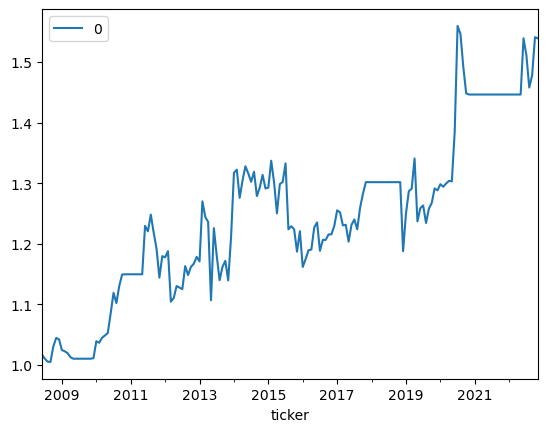

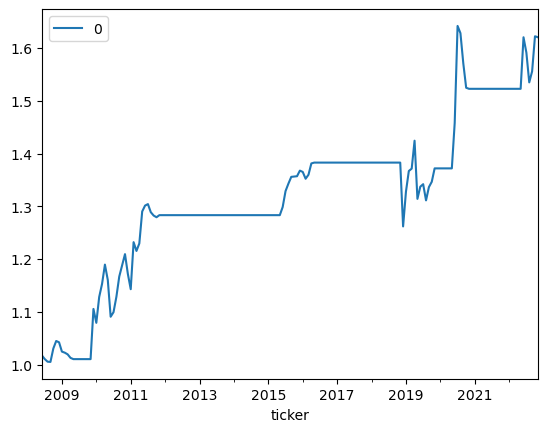

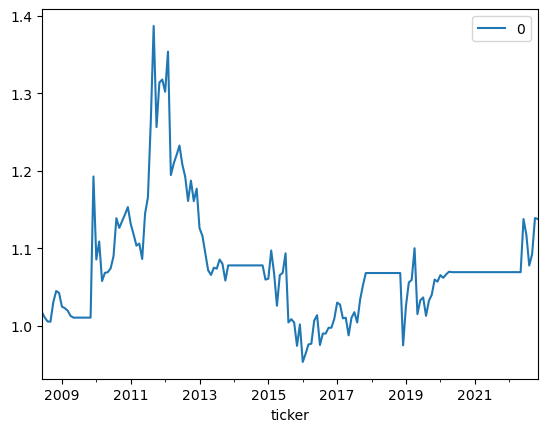

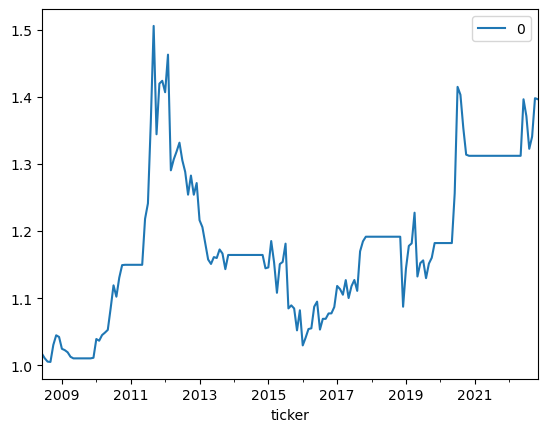

In [254]:
(experimental_results1['portfValue']/card_mvo[0].values).plot()
(experimental_results2['portfValue']/card_mvo[0].values).plot()
(experimental_results3['portfValue']/card_mvo[0].values).plot()
(experimental_results5['portfValue']/card_mvo[0].values).plot()
#CardMVO_results[('0.01', '0.75')][0].plot()

In [255]:
experimental_results1['portfValue']

,0
ticker,
2008-06-30,99813.875282
2008-07-31,100208.007897
2008-08-31,100952.332656
2008-09-30,99174.340338
2008-10-31,96914.867406
...,...
2022-07-31,878447.366204
2022-08-31,808516.689337
2022-09-30,729565.336993


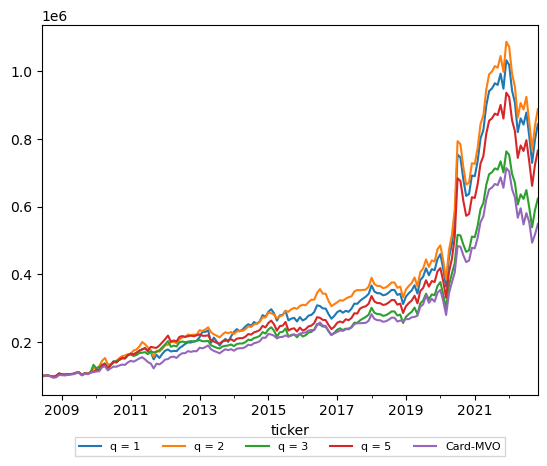

In [256]:
ax = plt.gca()
experimental_results1['portfValue'].columns = ['q = 1']
experimental_results2['portfValue'].columns = ['q = 2']
experimental_results3['portfValue'].columns = ['q = 3']
experimental_results5['portfValue'].columns = ['q = 5']
experimental_results1['portfValue'].plot(ax = ax, legend = False,  label = 'q = 1')
experimental_results2['portfValue'].plot(ax = ax, legend = False, label = 'q = 2')
experimental_results3['portfValue'].plot(ax = ax, legend = False, label = 'q = 3')
experimental_results5['portfValue'].plot(ax = ax, legend = False, label = 'q = 5')

card_mvo[0].plot(ax = ax, legend = False,  label = 'CardMVO')
ax.legend(loc='upper center',
                                          bbox_to_anchor=(0.5, -0.1),
                                          fancybox=False,
                                          shadow=False, ncol=5,
                                          fontsize=8)
#plt.legend();

In [239]:
calculate_return_stats(experimental_results1['portfValue'], riskFree)

(0.14388405440619412,
 0.20536493671414704,
 0.7006261960213304,
 1.14210423878514)

In [240]:
calculate_return_stats(experimental_results2['portfValue'], riskFree)

(0.14749087410853523,
 0.19342845910515702,
 0.7625086545736897,
 1.271190355037457)

In [241]:
calculate_return_stats(experimental_results3['portfValue'], riskFree)

(0.12268237736920717,
 0.17751061295916631,
 0.6911269998117151,
 1.105502518364055)

In [257]:
calculate_return_stats(experimental_results5['portfValue'], riskFree)

(0.13704220784946308,
 0.19167915796738877,
 0.714956228432403,
 1.2164718302948432)

In [896]:
def calculate_return_stats(portfValue, riskFree):
    portfRets = portfValue.pct_change(1).iloc[1:, :]
    # Calculate the portfolio excess returns
    portfExRets = portfRets.subtract(
        riskFree[(riskFree.index >= portfRets.index[0]) & (riskFree.index <= portfRets.index[-1])], axis=0)

    # Calculate the portfolio Sharpe ratio
    Ret = 12 * ((portfExRets + 1).apply(gmean, axis=0) - 1)
    Vol = (12 ** 0.5) * (portfExRets.std())
    SR = (12 ** 0.5) * (((portfExRets + 1).apply(gmean, axis=0) - 1) / portfExRets.std())
    Sortino = (12**0.5)*(((portfExRets + 1).apply(gmean, axis=0) - 1)/portfExRets.loc[portfExRets.values < 0].std())
    # Calculate the average turnover rate

    return Ret.iloc[0], Vol.iloc[0], SR.iloc[0]  , Sortino.iloc[0]

In [210]:
calculate_return_stats(experimental_results['portfValue'], riskFree)

(0.14749087410853523,
 0.19342845910515702,
 0.7625086545736897,
 1.271190355037457)

In [211]:
calculate_return_stats(card_mvo[0], riskFree)

(0.1148516912344002,
 0.16477159591457888,
 0.6970357396668159,
 1.044779304409962)